In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import itertools

# Read in Pickle

In [2]:
X_train = pd.read_pickle('./data/X_train_pickle.pkl')

X_test = pd.read_pickle('./data/X_test_pickle.pkl')

y_train = pd.read_pickle('./data/y_train_pickle.pkl')

y_test = pd.read_pickle('./data/y_test_pickle.pkl')

## KNN

#### Find optimal value for K

In [4]:
k_range = list(range(1, 13))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    score = metrics.f1_score(y_test, y_predict, average='weighted')
    k_scores.append(score)
print(k_scores)

1
2
3
4
5
6
7
8
9
10
11
12
[0.7893464608598852, 0.7871084939919836, 0.8039086438914108, 0.7999591723874191, 0.8104587106227014, 0.8085973589196299, 0.8143193722085645, 0.808315833971389, 0.8180100876743522, 0.8145689811762993, 0.819160830626904, 0.8150743178982968]


([<matplotlib.axis.XTick at 0x1a1fd5af60>,
 <a list of 11 Text xticklabel objects>)

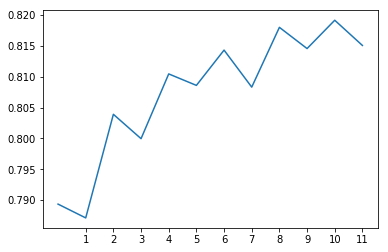

In [26]:
plt.plot(k_scores)
plt.xticks(ticks=np.arange(1, 12, step=1))

#### The optimal value of k is 11. K=10 has a higher F1 score, but it is best to choose an odd value for k

In [14]:
knn = KNeighborsClassifier(n_neighbors=11)

knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)

#### How to plot Confusion Matrix
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[4101  426]
 [ 631  841]]


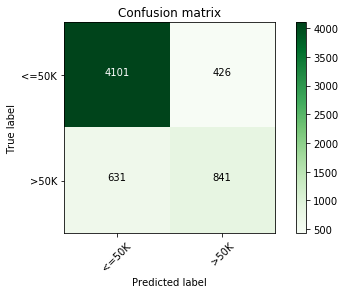

In [16]:
cm = confusion_matrix(y_test,y_pred_class)
classes = ['<=50K', '>50K']
plot_confusion_matrix(cm, classes=classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Greens)

In [25]:
cm[1][1]/(cm[1][1] + cm[1][0])

0.5713315217391305

The number of Positives that were correctly identified are 57% of the actual Positives that exist in the dataset. Therefore, KNN is not the best classification algorithm to use in this case. This is also known as Recall.

We want to use Recall as a way to compare the effectiveness of different algorithms because we would rather falsely predict a lower salary of an individual(False Negatives), so that they could adequately prepare themselves financially. We would not want to falsely predict higher salaries for individuals, so that they will not have to deal with financial complications(False Positives).